In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.3.0
aiohttp                      3.8.3
aiosignal                    1.2.0
anyio                        3.5.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        21.4.0
Babel                        2.9.1
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       4.1.0
blis                         0.7.9
Bottleneck                   1.3.5
brotlipy                     0.7.0
cachetools                   5.2.0
catalogue                    2.0.8
certifi                      2022.9.24
cffi                         1.15.1
charset-normalizer           2.0.4
click                        8.1.3
colorama                     0.4.5
colour                       0.1.5
confection                   0.0.3
cry

In [14]:
import tensorflow as tf
import os as os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
gpus = tf.config.experimental.list_physical_devices('CPU')

In [8]:
len(gpus)

1

In [9]:
gpus_local = tf.config.experimental.list_logical_devices('GPU')

In [10]:
len(gpus_local)

0

In [11]:
data_dir = 'data'

In [12]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data\Alges\algae-bloom-polluted-green-river-260nw-1493420024 - Copy.jpg
Image not in ext list data\Alges\algae-bloom-polluted-green-river-260nw-1493420024.jpg
Image not in ext list data\Alges\oilgae_wastewater - Copy.gif
Image not in ext list data\Alges\oilgae_wastewater.gif
Image not in ext list data\Alges2\180D0B5D181D0BDD0BED0B2D0BED0B4D0BDD0BED0B3D0BE_D0B2D0BED0B4D0BED0B5D0BCD0B0.jpg
Image not in ext list data\Alges2\192px.svg
Image not in ext list data\Alges2\1BJlheHVCtQhU1Q58vCekJA.jpeg
Image not in ext list data\Alges2\algae-bloom-polluted-green-river-260nw-1493420024.jpg
Image not in ext list data\Alges2\algae.GIF.jpg
Image not in ext list data\Alges2\blur-group-green-algae-capture-260nw-720310891.jpg
Image not in ext list data\Alges2\c5mb00319a-f1_hi-res.gif
Image not in ext list data\Alges2\oilgae_wastewater.gif
Image not in ext list data\Alges2\vector-anatomy-euglena-educational-illustration-260nw-1712011054.jpg


In [15]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 442 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

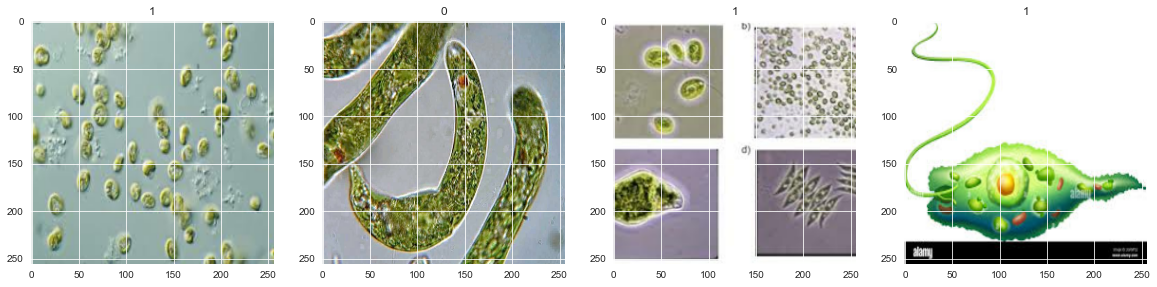

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [19]:
data = data.map(lambda x,y: (x/255, y))

In [20]:
data.as_numpy_iterator().next()

(array([[[[0.5235294 , 0.39019608, 0.29215688],
          [0.45931372, 0.3245098 , 0.23382352],
          [0.39803922, 0.26078433, 0.18235295],
          ...,
          [0.19313726, 0.06764706, 0.0245098 ],
          [0.20294118, 0.075     , 0.04166667],
          [0.22892156, 0.09950981, 0.07205883]],
 
         [[0.48219976, 0.34886643, 0.2508272 ],
          [0.47970665, 0.34490272, 0.25421646],
          [0.43338695, 0.29613206, 0.21770068],
          ...,
          [0.20156632, 0.07607614, 0.02586933],
          [0.19097733, 0.06439568, 0.02127374],
          [0.2155982 , 0.08836167, 0.0516659 ]],
 
         [[0.4456074 , 0.31227404, 0.21423483],
          [0.49216068, 0.35735676, 0.2666705 ],
          [0.45089614, 0.31364125, 0.23520987],
          ...,
          [0.21958104, 0.09573376, 0.03113128],
          [0.18882889, 0.06434973, 0.00591299],
          [0.19833027, 0.0738511 , 0.02619485]],
 
         ...,
 
         [[0.56043196, 0.45503983, 0.35013786],
          [0.45662

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
val_size

In [22]:
train_size

9

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [24]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model = Sequential()